Coral Locations are obtained from a Benthic Ecological Survey (BES) conducted along the coasts of Tanzania

In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

In [5]:
inf_lat = -10.5289526
sup_lat = -4.5
left_lon = 37.61999893
right_lon = 43.61999893
extent = [left_lon-0.1, right_lon+0.1, sup_lat+0.1, inf_lat-0.1]

In [6]:
csvFile = pd.read_csv('/mnt/iscsi2/OceanParcels/InputObsDom/BES_site_summaries_HC_Short.csv')
ds_cells_obs = csvFile[((csvFile['Longitude'] >= left_lon) & (csvFile['Longitude'] < right_lon)) & ((csvFile['Latitude'] >= inf_lat) & (csvFile['Latitude'] < sup_lat))]
ds_cells_obs = ds_cells_obs.drop(columns=['ID','Depth','Coral'])

### Deleting points outside the domain of WINDS dataset (so on land)

Importing the velocity field (here v-field, but it is ok also u-field and mesh)

In [7]:
days100_from_april_1997_velocity_v_OK = xr.open_dataset("/mnt/iscsi2/OceanParcels/InputObsDom/days100_from_april_1997_velocity_v_OK.nc")

# Just renaming for a better handling
v_surf = days100_from_april_1997_velocity_v_OK.v_surf[0,:,:].values
lon_v = days100_from_april_1997_velocity_v_OK.nav_lon_rho[0,:].values
lat_v = days100_from_april_1997_velocity_v_OK.nav_lat_rho[:,0].values

# Function to find the nearest index in a sorted array
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx


In [8]:
# Filtering the locations
filtered_lon_list = []
filtered_lat_list = []

for lon, lat in zip(ds_cells_obs['Longitude'].values, ds_cells_obs['Latitude'].values):
    # Finding the nearest grid cell in the velocity field
    lon_idx = find_nearest(lon_v, lon)
    lat_idx = find_nearest(lat_v, lat)
    
    # Checking if the point is within the bounds of the velocity field
    if 0 <= lon_idx < len(lon_v) and 0 <= lat_idx < len(lat_v):
        # Checking if the velocity value at this location is non-zero
        if v_surf[lat_idx, lon_idx] != 0:
            filtered_lon_list.append(lon)
            filtered_lat_list.append(lat)

In [9]:
np.save('/mnt/iscsi2/OceanParcels/InputObsDom/filtered_lat_list.npy' ,filtered_lat_list)
np.save('/mnt/iscsi2/OceanParcels/InputObsDom/filtered_lon_list.npy',filtered_lon_list)

In [10]:
# Square size (0.02 to the left, to the right, above and below every 1133 filtered points)
dx = 0.02
dy = 0.02

# Number of random points per square
num_points = 10

# Set random seed for reproducibility
np.random.seed(42)

# Latitude and Longitude of the 1133x10 points
random_latitudes = []
random_longitudes = []

# Generating random points within squares
for lon, lat in zip(filtered_lon_list, filtered_lat_list):
    lower_lat = lat - dy
    upper_lat = lat + dy
    left_lon = lon - dx
    right_lon = lon + dx

    # Generating random points and ensure they are within valid cells of the velocity field
    generated_points = 0
    while generated_points < num_points:
        random_lat = np.random.uniform(lower_lat, upper_lat)
        random_lon = np.random.uniform(left_lon, right_lon)
        
        # Finding the nearest indices in the velocity field grid
        lon_idx = find_nearest(lon_v, random_lon)
        lat_idx = find_nearest(lat_v, random_lat)
        
        # Checking if the point is within the bounds and in a non-zero velocity cell
        if 0 <= lon_idx < len(lon_v) and 0 <= lat_idx < len(lat_v) and v_surf[lat_idx, lon_idx] != 0:
            random_latitudes.append(random_lat)
            random_longitudes.append(random_lon)
            generated_points += 1

In [11]:
np.save("/mnt/iscsi2/OceanParcels/InputObsDom/random_latitude_10250",random_latitudes)
np.save("/mnt/iscsi2/OceanParcels/InputObsDom/random_longitude_10250",random_longitudes)

Create CSV just for deliverable purposes

In [12]:
combined_array = np.column_stack((random_longitudes,random_latitudes ))

In [15]:
df = pd.DataFrame(combined_array, columns=["Longitude", "Latitude"])
df.to_csv("/mnt/iscsi2/OceanParcels/InputObsDom/random_releaselocations_10250.csv", sep="\t", index=False)

### Grouped locations used for the connectivity matrices (thesis case study)

In [33]:
inf_lat = -10.5289526
sup_lat = -4.48427153
left_lon = 37.61999893
right_lon = 43.61999893
extent = [left_lon-0.1, right_lon+0.1, sup_lat+0.1, inf_lat-0.1]

In [34]:
#First download the file and then name it as 'site_reference_grp_reordered.xlsx'
xlsFile = pd.read_excel('/mnt/iscsi2/OceanParcels/InputExtDom/site_reference_grp_reordered.xlsx')

# Select only the locations inside the domain
ds_grp_big = xlsFile[((xlsFile['Longitude'] >= left_lon) & (xlsFile['Longitude'] < right_lon)) & ((xlsFile['Latitude'] >= inf_lat) & (xlsFile['Latitude'] < sup_lat))]

# Drop the variables not relevant (keeping only Latitude and Longitude)
ds_grp = ds_grp_big.drop(columns=['Group number','L2 Group','L1 Group','Country','Reef area'])

In [35]:
# Function to find the nearest index in a sorted array
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

# Filtering the locations
group_lon_list = []
group_lat_list = []

for lon, lat in zip(ds_grp['Longitude'].values, ds_grp['Latitude'].values):
    # Finding the nearest grid cell in the velocity field
    lon_idx = find_nearest(lon_v, lon)
    lat_idx = find_nearest(lat_v, lat)
    
    # Checking if the point is within the bounds of the velocity field
    if 0 <= lon_idx < len(lon_v) and 0 <= lat_idx < len(lat_v):
        # Checking if the velocity value at this location is non-zero
        if v_surf[lat_idx, lon_idx] != 0:
            group_lon_list.append(lon)
            group_lat_list.append(lat)

The new_corals_lon were created by Andrea Valli and I use it here to extract some extra locations for the clusetered locations

In [36]:
new_corals_lon = np.array([39.73223114, 39.6405884, 39.500, 39.92, 39.47441864, 39.50928879,
        39.9375    , 39.56, 39.34, 39.26, 39.03000259, 38.9177742 ,
        39.13373184, 39.30393982, 39.60278183, 39.4683342 , 39.18, 39.42,
        38.88454819, 39.01739502, 39.10639954, 39.20000076, 39.26356888,
        39.6333313 , 39.86, 39.88, 39.7731514 , 39.64492798, 39.36883545,
        39.53882599, 39.67703629, 39.89500046, 40.05157852, 40.23666763,
        40.67300415, 40.98210526]) 

new_corals_lat = np.array([-8.01682186, -7.69152546, -7.99, -7.745, -7.48969936, -7.23591518,
        -6.89461374, -6.982, -6.809, -6.594,  -6.45777082, -6.18345165,
        -6.16138983, -6.36267281, -6.37120247, -6.0890007 , -5.877, -5.776,
        -5.79438543, -5.54667282, -5.28294134, -5.02995682, -4.80961895,
        -5.42941427, -5.304, -5.048 , -4.86327362, -5.17221212, -4.68640804,
        -4.43031645, -4.12676477, -3.63475347, -3.35852289, -2.85103106,
        -2.55003238, -2.24830103])

In [37]:
list=[7,8,14,16,17,23,25]
extra_lat=new_corals_lat[list]
extra_lon=new_corals_lon[list]

These two arrays are the results of the selection group_lon/lat_list done above + some extra points created by andrea + 2 points added by me 

In [38]:
lat_corals_grp=[-10.2843542098999, -10.1989526748657, -10.0264263153076, -9.71188545227051,
-9.37960529327393, -9.05581474304199, -8.82572746276856, -8.55892086029053, -8.34731674194336, 
-8.33635139465332,-8.18,-8.01682186126709, -7.69152545928955, -7.94768905639648, -7.4896993637085, -7.55,
-7.235915184021,extra_lat[0], -6.89461374282837,extra_lat[1],-6.63434982299805, -6.45777082443237, -6.18345165252686, 
-6.16138982772827, -6.36267280578613,-6.0890007019043,extra_lat[2],extra_lat[3],extra_lat[4], -5.79438543319702, -5.54667282104492, 
-5.28294134140015, -5.02995681762695,-4.80961894989014, -4.86327362060547, -5.17221212387085,extra_lat[5],extra_lat[6]]

In [39]:
lon_corals_grp=[40.3539161682129, 40.1761283874512, 39.8887825012207, 39.7582321166992,
 39.6556510925293, 39.5909957885742, 39.5418853759766, 39.4873313903809, 39.3827438354492,
 39.554759979248,39.6, 39.7322311401367, 39.7540588378906, 39.5583915710449, 39.4744186401367, 39.7,
 39.5092887878418,extra_lon[0],39.9375, extra_lon[1],39.2371444702148, 39.0300025939941, 38.9177742004395,
 39.133731842041, 39.3039398193359, 39.468334197998, extra_lon[2],extra_lon[3],extra_lon[4],38.8845481872559, 39.0173950195312,
 39.1063995361328, 39.2000007629395, 39.2635688781738, 39.7731513977051, 39.6449279785156,extra_lon[5],extra_lon[6]]

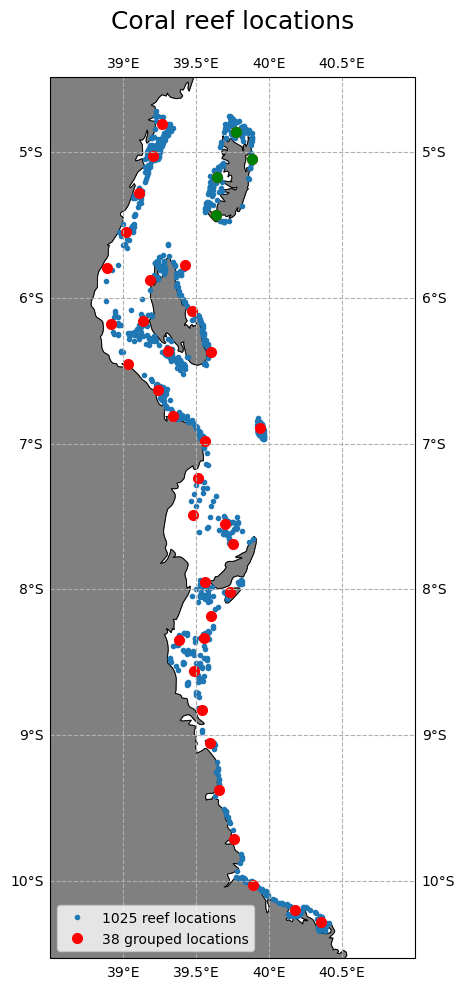

In [31]:
extent_thin = [38.5, 41.,-4.48427153 , -10.5289526]
plt.figure(figsize=(10, 10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=2, edgecolor = 'black', linewidth=0.5, facecolor='gray', alpha=1)
ax.plot(filtered_lon_list,filtered_lat_list,'.',markersize=6,label='1025 reef locations')
ax.plot(lon_corals_grp,lat_corals_grp,'.r',markersize=14,label='38 grouped locations' )
ax.gridlines(draw_labels=True, linestyle='--')
ax.set_extent(extent_thin, crs=ccrs.PlateCarree())
plt.title('Coral reef locations', fontsize=18, pad=20)
ax.legend()

plt.tight_layout()

filename=f'/mnt/iscsi2/OceanParcels/OBS_Figures/Coral_reef_locations_1025_38.png'
plt.savefig(filename)

In [57]:
np.save("/mnt/iscsi2/OceanParcels/InputObsDom/corals_grp_latitude.npy",lat_corals_grp)
np.save("/mnt/iscsi2/OceanParcels/InputObsDom/corals_grp_longitude.npy",lon_corals_grp)